# Multilingual Embeddings - 2. Cross-lingual Sentence Similarity

In our second and third notebook on multilingual embeddings, we're going to explore some more practical applications. Let's start with cross-lingual sentence similarity. As we've seen [before](Simple%20Sentence%20Similarity.ipynb), pretrained word embeddings can help us determine the semantic similarity between two sentences. However, when you're working with monolingual embeddings, you can only compute the similarity in meaning between two sentences in the same language. This is a downside. In applications like search engines or question answering systems, it's often practical if you can search documents or questions and answers in more than one language.

# Data

For our experiments, we're going to use the questions from [Kaggle's Quora Question Pairs challenge](https://www.kaggle.com/c/quora-question-pairs). The Quora data contains all pressing questions of life, from _How can I destroy the world?_ to _How do I find a good escort?_, and many more.

The training and test set for this challenge consist of question pairs with duplicate or non-duplicate questions. Because the questions are all in English, we take the first 1,000 questions from the training set and use Google Translate to translate the second question in the pair from English to French. Obviously, the translations are not always perfect, but for our purposes they are good enough. This gives us 1,000 data items, each with two English questions (`question1_en` and `question2_en`), the French translation of the second English question (`question2_fr`) and an indicate of whether the two questions are the same or not (`is_duplicate`).

In [2]:
%matplotlib inline
import pandas as pd

questions = pd.DataFrame.from_csv("data/multilingual_embeddings/questions.csv")
questions.head()

,question1_en,question2_en,question2_fr,is_duplicate
id,,,,
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,Quel est le guide étape par étape pour investi...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,Que se passerait-il si le gouvernement indien ...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,Comment augmenter la vitesse d'Internet en pir...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,Trouvez le reste lorsque [math] 23 ^ {24} [/ m...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,Quel poisson survivrait dans l'eau salée?,0


## Embeddings

In our previous notebook, we transformed two sets of monolingual embeddings into multilingual ones by projecting them into a shared multilingual vector space. This time we're going to skip that step and download embeddings that already share the same vector space. These embeddings, and the code to obtain them, are provided by the [MUSE](https://github.com/facebookresearch/MUSE) library from Facebook Research.

In [3]:
!wget https://s3.amazonaws.com/arrival/embeddings/wiki.multi.fr.vec -O /tmp/wiki.multi.fr.vec
!wget https://s3.amazonaws.com/arrival/embeddings/wiki.multi.en.vec -O /tmp/wiki.multi.en.vec

--2018-08-13 14:14:55--  https://s3.amazonaws.com/arrival/embeddings/wiki.multi.fr.vec
Resolving s3.amazonaws.com... 54.231.98.163
Connecting to s3.amazonaws.com|54.231.98.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628737710 (600M) [text/plain]
Saving to: '/tmp/wiki.multi.fr.vec'

/tmp/wiki.multi.fr. 100%[=====================>] 599.61M  7.02MB/s   in 88s    s

2018-08-13 14:16:24 (6.80 MB/s) - '/tmp/wiki.multi.fr.vec' saved [628737710/628737710]

--2018-08-13 14:16:24--  https://s3.amazonaws.com/arrival/embeddings/wiki.multi.en.vec
Resolving s3.amazonaws.com... 52.216.164.165
Connecting to s3.amazonaws.com|52.216.164.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628614720 (599M) [text/plain]
Saving to: '/tmp/wiki.multi.en.vec'

/tmp/wiki.multi.en. 100%[=====================>] 599.49M  7.28MB/s   in 91s    

2018-08-13 14:17:56 (6.59 MB/s) - '/tmp/wiki.multi.en.vec' saved [628614720/628614720]



In [3]:
from gensim.models import KeyedVectors

fr_embeddings = KeyedVectors.load_word2vec_format("/tmp/wiki.multi.fr.vec")
en_embeddings = KeyedVectors.load_word2vec_format("/tmp/wiki.multi.en.vec")

## Smooth Inverse Frequency

In [an earlier notebook](Simple%20Sentence%20Similarity.ipynb), we experimented with a number of ways to compute semantic similarity. Smooth Inverse Frequency stood out as a simple but effective way of calculating the similarity in meaning between two sentences. It calculates the embedding of a sentence by taking the weighted sum of its word embeddings and then removing the first principal component from a set of sentence embeddings. Let's reuse that implementation here. 

In [4]:
import nltk
import numpy as np
from wordfreq import word_frequency
from sklearn.decomposition import TruncatedSVD

def remove_first_principal_component(X):
    svd = TruncatedSVD(n_components=1, n_iter=7, random_state=0)
    svd.fit(X)
    pc = svd.components_
    XX = X - X.dot(pc.transpose()) * pc
    return XX


def compute_sentence_embeddings(questions, word_embeddings, language, a=0.001): 
    
    question_embeddings = []
    for question in questions: 
        tokens = [t.lower() for t in nltk.word_tokenize(question)]
        tokens = [token for token in tokens if token in word_embeddings]

        weights = [a/(a+word_frequency(token, language)) for token in tokens]
        embedding = np.average([word_embeddings[token] for token in tokens], axis=0, weights=weights)
        question_embeddings.append(embedding)
        
    question_embeddings = remove_first_principal_component(np.array(question_embeddings)) 
    return question_embeddings

## Question similarity 

In our first experiment, we'd like to find out whether the embeddings of two duplicate questions are indeed more similar than the embeddings of non-duplicate sentences. To this goal, we compute two types of similarity. First we take a look at a simple baseline, which calculcates the similarity between two questions as the cosine between their tf-idf weighted token vectors. We expect in particular that the tf-idf token vectors of two English duplicate questions should display a higher cosine similarity than non-duplicate ones. Moreover, these tf-idf vectors may also tell us whether an English and a French question are duplicates, simply because duplicate questions in different languages often still share content words, such as proper nouns.

Second, we calculate the similarities on the basis of the sentence embeddings obtained with Smooth Inverse Frequency. For the English question pairs, the original word embeddings should be perfectly comparable. For the English-French question pairs, the word embeddings have been projected into a shared multilingual space by the makers of the MUSE library. The resulting sentence embeddings should therefore also be more similar for duplicate questions.

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_en = TfidfVectorizer()
tfidf_en.fit(questions["question1_en"] + questions["question2_en"])

tfidf_enfr = TfidfVectorizer()
tfidf_enfr.fit(questions["question1_en"] + questions["question2_fr"])

questions1_all_en_emb = compute_sentence_embeddings(questions["question1_en"], en_embeddings, "en")
questions2_all_en_emb = compute_sentence_embeddings(questions["question2_en"], fr_embeddings, "en")
questions2_all_fr_emb = compute_sentence_embeddings(questions["question2_fr"], fr_embeddings, "fr")

questions1_all_en_tfidf_en = tfidf_en.transform(questions["question1_en"])
questions2_all_en_tfidf_en = tfidf_en.transform(questions["question2_en"])

questions1_all_en_tfidf_enfr = tfidf_enfr.transform(questions["question1_en"])
questions2_all_fr_tfidf_enfr = tfidf_enfr.transform(questions["question2_fr"])

questions["tfidf_en_sim"] = [cosine_similarity(q1.reshape(1, -1), q2.reshape(1, -2))[0,0]
                            for q1, q2 in zip(questions1_all_en_tfidf_en, questions2_all_en_tfidf_en)]

questions["tfidf_enfr_sim"] = [cosine_similarity(q1.reshape(1, -1), q2.reshape(1, -2))[0,0]
                               for q1, q2 in zip(questions1_all_en_tfidf_enfr, questions2_all_fr_tfidf_enfr)]

questions["emb_en_sim"] = [cosine_similarity(q1.reshape(1, -1), q2.reshape(1, -1))[0,0]
                        for q1, q2 in zip(questions1_all_en_emb, questions2_all_en_emb)]

questions["emb_enfr_sim"] = [cosine_similarity(q1.reshape(1, -1), q2.reshape(1, -1))[0,0]
                        for q1, q2 in zip(questions1_all_en_emb, questions2_all_fr_emb)]


The statistics and box plots below confirm our hypotheses:

- The tf-idf weighted token vectors of English duplicate questions are much more similar than those of non-duplicate questions, on average (top left).
- The tf-idf weighted token vectors of French-English duplicate questions are sometimes more similar than those of non-duplicate questions, but not very often so. The median similarity of 0 for both duplicate and non-duplicate question pairs suggests that the tokens in the French and English questions overlap very rarely. We therefore need multilingual word embeddings to compute cross-lingual question similarity more reliably (top right).
- The monolingual embedding similarity of English duplicate questions is much higher (mean 0.37) than that of non-duplicate questions (mean 0.27).
- The cross-lingual embedding similarity of English-French duplicate questions is much higher (mean 0.45) than that of non-duplicate questions (mean 0.34). This indicates that multilingual embeddings can offer a effective way of computing the similarity between two sentences in different languages. 

Statistics for duplicate questions
       is_duplicate  tfidf_en_sim  tfidf_enfr_sim  emb_en_sim  emb_enfr_sim
count         380.0    380.000000      380.000000  380.000000    380.000000
mean            1.0      0.638715        0.124023    0.366415      0.451182
std             0.0      0.186349        0.161170    0.129386      0.147608
min             1.0      0.202784        0.000000   -0.013510     -0.030055
25%             1.0      0.504326        0.000000    0.276244      0.360803
50%             1.0      0.640752        0.000000    0.373828      0.458813
75%             1.0      0.771543        0.232909    0.446307      0.552400
max             1.0      1.000000        0.713550    0.720830      0.812218
Statistics for non-duplicate questions
       is_duplicate  tfidf_en_sim  tfidf_enfr_sim  emb_en_sim  emb_enfr_sim
count         620.0    620.000000      620.000000  620.000000    620.000000
mean            0.0      0.405504        0.074067    0.272758      0.339462
std           

/Users/yvespeirsman/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x149f00cc0>,
      dtype=object)

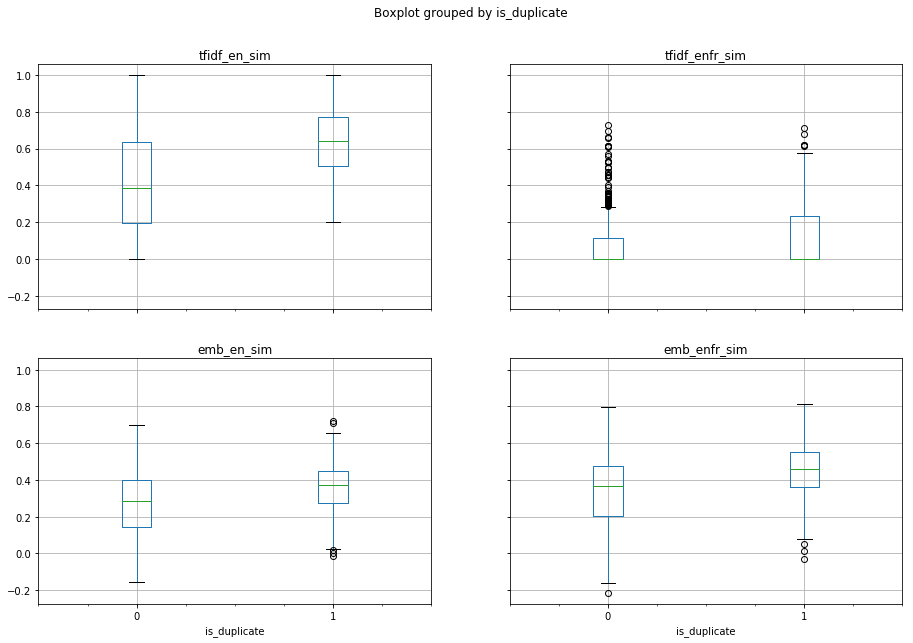

In [6]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Descriptive statistics
print("Statistics for duplicate questions")
print(questions.loc[questions["is_duplicate"] == 1].describe())
print("Statistics for non-duplicate questions")
print(questions.loc[questions["is_duplicate"] == 0].describe())

# Figure
plt.rcParams['figure.figsize'] = (15,10)
columns = ["tfidf_en_sim", "tfidf_enfr_sim", "emb_en_sim", "emb_enfr_sim"]
questions.boxplot(column=columns, by="is_duplicate", layout=(2,2))

## Question retrieval

Now suppose we're building a search engine of question and answers. We would like to match a user question to existing questions in our database, irrespective of their language, English or French. Let's simulate this setup by selecting from our data the 380 French-English duplicate question pairs. For each English question, we would like to identify the most related question from all 380 French questions. If we do this correctly, this French question should have the same index of the English question, because they belong to the same pair. 

We again start by investigating a simple baseline that identifies from the 380 French questions the question with the most similar tf-idf weighted token vector. It gives us the correct question in 34% of the cases, thanks to the shared words between the two languages (as in _What does manipulation mean?_ = _Que signifie la manipulation?_) and the presence of proper nouns (as in _Who are the Rohingya Muslims?_ = _Qui sont les Rohingya?_).


In [7]:
import numpy as np

duplicates_en = list(questions["question1_en"].loc[questions["is_duplicate"] == 1])
duplicates_fr = list(questions["question2_fr"].loc[questions["is_duplicate"] == 1])

duplicates_en_tfidf = tfidf_enfr.transform(duplicates_en)
duplicates_fr_tfidf = tfidf_enfr.transform(duplicates_fr)

similarity_matrix = cosine_similarity(duplicates_en_tfidf, duplicates_fr_tfidf)

def evaluate_similarity_matrix(similarity_matrix, verbose=1): 
    correct, total = 0, 0
    for (idx, row) in enumerate(similarity_matrix): 
        matching_index = np.argmax(row)
        if verbose == 1:
            print(idx, duplicates_en[idx])
            print(matching_index, duplicates_fr[matching_index])
        if idx == matching_index:
            correct += 1 
        elif verbose == 1:
            print("=>", duplicates_fr[idx])
        
        if verbose == 1: 
            print("--")
        total += 1
    return correct/total

acc_baseline = evaluate_similarity_matrix(similarity_matrix)
print("Baseline accuracy:", acc_baseline)

0 Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
87 Dans "A Raisin in the Sun", pourquoi Walter et Beneatha se disputent-ils?
=> Je suis un triple Capricorne (Soleil, Lune et ascendant en Capricorne) Qu'est-ce que cela dit de moi?
--
1 How can I be a good geologist?
0 Je suis un triple Capricorne (Soleil, Lune et ascendant en Capricorne) Qu'est-ce que cela dit de moi?
=> Que dois-je faire pour être un grand géologue?
--
2 How do I read and find my YouTube comments?
216 Comment gagner de l'argent via YouTube?
=> Comment puis-je voir tous mes commentaires sur Youtube?
--
3 What can make Physics easy to learn?
0 Je suis un triple Capricorne (Soleil, Lune et ascendant en Capricorne) Qu'est-ce que cela dit de moi?
=> Comment pouvez-vous rendre la physique facile à apprendre?
--
4 What was your first sexual experience like?
0 Je suis un triple Capricorne (Soleil, Lune et ascendant en Capricorne) Qu'est-ce que cela dit de moi?
=> Quelle a été votre prem

Multilingual embeddings should do better than that. We again use Smooth Inverse Frequency to obtain the sentence embeddings for the French and English questions and now select the French question with the highest embedding similarity with the English query. This performs much better: it identifies the duplicate French question in 71% of the cases, even when the questions do not share a single word (as in _How should I start meditating?_ = _Comment devrais-je commencer à méditer et quand?_).

In [10]:
duplicates_en_emb = compute_sentence_embeddings(duplicates_en, en_embeddings, "en")
duplicates_fr_emb = compute_sentence_embeddings(duplicates_fr, fr_embeddings, "fr")

similarity_matrix_emb = cosine_similarity(duplicates_en_emb, duplicates_fr_emb)
acc_embedding = evaluate_similarity_matrix(similarity_matrix_emb)
print("Embedding accuracy:", acc_embedding)

0 Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
0 Je suis un triple Capricorne (Soleil, Lune et ascendant en Capricorne) Qu'est-ce que cela dit de moi?
--
1 How can I be a good geologist?
1 Que dois-je faire pour être un grand géologue?
--
2 How do I read and find my YouTube comments?
2 Comment puis-je voir tous mes commentaires sur Youtube?
--
3 What can make Physics easy to learn?
3 Comment pouvez-vous rendre la physique facile à apprendre?
--
4 What was your first sexual experience like?
4 Quelle a été votre première expérience sexuelle?
--
5 What would a Trump presidency mean for current international master’s students on an F1 visa?
5 Comment une présidence Trump affectera-t-elle les étudiants actuellement aux États-Unis ou prévoit-elle d'étudier aux États-Unis?
--
6 What does manipulation mean?
6 Que signifie la manipulation?
--
7 Why are so many Quora users posting questions that are readily answered on Google?
7 Pourquoi les gens posent-

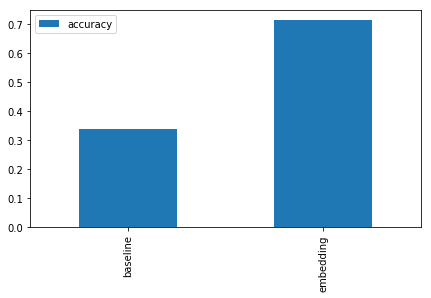

In [11]:
df = pd.DataFrame({"accuracy": {"baseline": acc_baseline, "embedding": acc_embedding}})
plt.rcParams['figure.figsize'] = (7,4)
df.plot(kind="bar")

## Conclusions

Our simple experiments show multilingual word embeddings can effectively model the semantic similarity between two sentences in different languages. This allows us to build cross-lingual search engines or question-answering applications. Still, multilingual embeddings can do more than that: they can also help us transfer a trained NLP model from one language to the other. That's the topic of our next [notebook on Transfer Learning](Multilingual%20Embeddings%20-%203.%20Transfer%20Learning.ipynb).